In [1]:
# Use vector graphics for plots. 
# Change svg to png in the following line and re-run everything via cell > run all, if your browser struggles.
%config InlineBackend.figure_format = 'svg' 

In [2]:
%pylab inline
pylab.rcParams['figure.dpi'] = 328
# Reduce the default size of the figures here a little bit
pylab.rcParams['figure.figsize'] = (5, 3)

Populating the interactive namespace from numpy and matplotlib


# Simulation

In the previous tutorials, we have shown how to define the model in ``MEANS`` format.
We are going to skip these steps in the present tutorial and just import the sample model from ``means.examples`` package:

In [3]:
import means
import means.examples
# Let's use the P53 Model from means.examples
my_model = means.examples.MODEL_P53

## ODE Simulations

Similarly, in the previous tutorials we have shown how to use LNA or MEA to generate systems of ODEs (*i.e.* a problem) describing the temporal evolution of models.
Here we create a set of these ordinary differential equations using MEA with log-normal closure for moments up to order 3.

In [4]:
ode_logn = means.mea_approximation(my_model, 3, closure='log-normal', 
                                   multivariate=True)

`MEANS` package uses `Assimulo` as ODE solving back-end. Therefore `MEANS` supports all solvers implemented in `Assimulo`.
Available solvers are fully listed in the documentation with links to the appropriate pages in ``Assimulo`` documentation.
Programmatically, these solvers can also be accessed via the ``.supported_solvers()`` method in the ``Simulation`` class:

In [5]:
means.Simulation.supported_solvers()

['cvode',
 'dopri5',
 'euler',
 'lsodar',
 'ode15s',
 'radau5',
 'rodas',
 'rungekutta34',
 'rungekutta4']

The default solver is `ode15s`, which is a CVODE solver with parameters set to simulate the behaviour of `MATLAB` function with the same name.

Simulation have many optional arguments, and it might be wise to read both ``MEANS`` and ``Assimulo`` documentations before starting serious work with any solver, otherwise we suggest to use the default solver.

In order to perform simulations, one must first create a ``Simulation`` object. 
The creation of this object involves an instance of ``ODEProblem`` (returned by ``mea_approximation()`` or ``mea_approximation()``), the solver name, and an optional set of solver parameters. 

Minimally, this instantiation looks like this:

In [6]:
simulation = means.Simulation(ode_logn)

If alternative solver is desired, it can be passed via the optional ``solver='solver-name'`` argument, for instance, `CVODE` solver here:

In [7]:
simulation_cvode = means.Simulation(ode_logn, solver='cvode')

The actual simulations are performed by the ``Simulation.simulate_system(parameters, initial_conditions, timepoints)`` function.

This function takes the following arguments:

* values for the *parameters* (constants) of the model (typically, $[c_0, ... ,c_n]$)
* values for the *initial conditions* (concentrations of the species at starting time of the simulation, assumed zero for the ones that were not specified)
* A *list of timepoints* specifying at which time points to return simulation results (typically, ``np.arange`` function would be used). Simulation is assumed to start at the first timepoint given in this list and end at the last one.

See the first section of the tutorial for information about parameters and species.

The function returns a collection of ``Trajectory`` objects, each containing a list of timepoints, values and a description.

Let us try a simulation of the above problem (p53 model):

In [8]:
# Values for parameters
parameters = [90, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01]
# Values for initial conditions
initial_conditions = [70, 30, 60]

# Timepoints
import numpy as np
timepoints = np.arange(0, 40, 0.1)

In [9]:
trajectories = simulation.simulate_system(parameters, 
                                          initial_conditions, 
                                          timepoints)

Could not find GLIMDA


The simulation above already gave us a collection of trajectories.
You can view them directly by just outputting from the particular notebook cell:

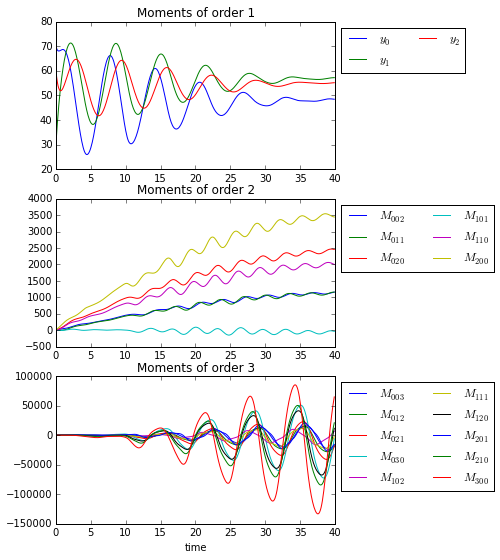

In [10]:
trajectories

Each individual trajectory can be accessed as if ``trajectories`` object was a list:

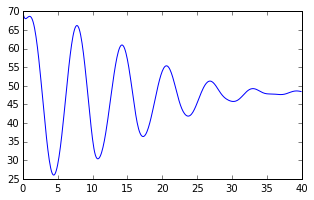

In [11]:
trajectories[0]

In [12]:
print trajectories[0]

Trajectory object
description: Moment(array([1, 0, 0]), symbol=y_0)
time points: [0.0, 0.1, 0.2, 0.3, ...,39.6, 39.7, 39.8, 39.9]
values: [70.0, 69.02, 68.43, 68.133, ...,48.569, 48.538, 48.501, 48.46]


### Reuse of Simulation Objects

Please, note that ``Simulation`` objects can be reused as long as the set of ODEs do not change.
Not only reusing of these objects is good practice, but it also reduces a large part of the runtime.
This is because the numerical routines implemented in our system allow you use caching mechanisms.

In other words, the very first simulation performed by the ``Simulation`` object always takes the longer.
Subsequent simulations will perform considerably faster because of the in-memory caching of numerical evaluation functions (*i.e.* they do not need to be recompiled), to illustrate let's perform the simulations three times with the same object:

In [13]:
# Effects are more obvious in the scalar closure case
ode = means.mea_approximation(my_model, 3) 
simulation_new = means.Simulation(ode)

First simulation:

In [14]:
%%time 
__ = simulation_new.simulate_system([90, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01],
                                    [70, 30, 60], 
                                    timepoints)

CPU times: user 813 ms, sys: 142 ms, total: 955 ms
Wall time: 18.4 s


Second simulation, considerably faster:

In [15]:
%%time 
__ = simulation_new.simulate_system([90, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01],
                                    [70, 30, 60], 
                                    timepoints)

CPU times: user 49.5 ms, sys: 6 ms, total: 55.5 ms
Wall time: 51.7 ms


Third simulation, speed increase stays even when the parameters change

In [16]:
%%time 
__ = simulation_new.simulate_system([95, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01], 
                                    [80, 30, 60], 
                                    timepoints)

CPU times: user 61.1 ms, sys: 8.29 ms, total: 69.4 ms
Wall time: 63.9 ms


If we did not reuse the same instance of simulation_new object, the timing results would all be as large as the first one.

### Plotting Trajectories

As we have already seen above, in most cases it is enough to just output the trajectory to IPython notebook and let it handle the plotting. This is convenient, but not very customisable.
In this section we will to show how to customise the trajectory plots.

Both ``TrajectoryCollection`` and ``Trajectory`` objects have a method and two attributes associated with plotting: ``.plot()``, ``.png`` and ``.svg``.

The ``.plot()`` method handles the plotting using ``matplotlib``. 
The ``.png`` and ``.svg`` methods provide a convenient way to access a PNG and SVG version of the plot through the IPython notebook.

By default, when a trajectory is outputted, it's SVG representation is drawn to the notebook. 
In some cases, this might slow down the browser considerably, and therefore PNG representations of the figures may be more desirable. They can be generated by explicitly calling ``.plot()`` or ``.png``:

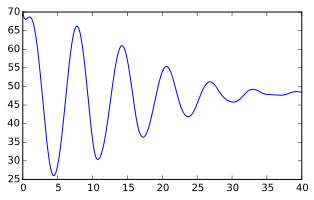

In [17]:
trajectories[0].plot()

Note that the ``.plot()`` method above also returns the line object, which `.png` doesn't

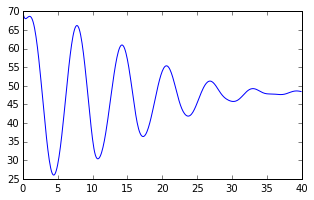

In [18]:
trajectories[0].png

Since ``TrajectoryCollection`` objects are essentially lists with additional plotting functionality, 
we can loop through all trajectories and perform plotting tasks based on some checks in the loops.

For instance, if we wanted to filter first-order moment trajectories to plot them:

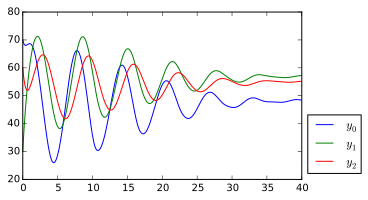

In [19]:
from matplotlib import pyplot as plt
# Create a new figure before we plot (optional, but good practice)
plt.figure() 
for trajectory in trajectories:
    # Trajectory descriptions are not necessarily moment objects,
    # always verify they are what you think they are first:
    if isinstance(trajectory.description, means.Moment): 
       if trajectory.description.order == 1:
           trajectory.plot()
    
    # Plot legend out of the plot axes:
    plt.legend(loc='lower left', bbox_to_anchor = (1, 0))

The `Trajectory.plot()` method implements all options available in `matplotlib.plot()`. For instance, it is straightforward to change the appearance of individual lines:

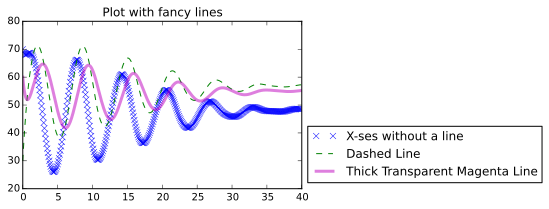

In [20]:
plt.figure() 
plt.title('Plot with fancy lines')
trajectories[0].plot(linestyle='None', marker='x', 
                     label='X-ses without a line')
trajectories[1].plot(linestyle="--", label='Dashed Line')
trajectories[2].plot(alpha= .5, linewidth=3, color="m",
                     label='Thick Transparent Magenta Line')

plt.legend(loc='lower left', bbox_to_anchor = (1, 0))

Trajectory objects also support basic arithmetic opperations, this can be used to plot the differences between trajectories conveniently, for instance.

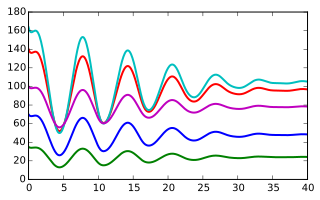

In [21]:
traj = trajectories[0]
tarject_list = []
tarject_list.append(traj)
tarject_list.append(traj / 2)
tarject_list.append(traj * 2)
tarject_list.append(traj ** 1.2)
tarject_list.append(traj + 30)

plt.figure()
for t in tarject_list:
    t.plot(linewidth=2)

Note that one cannot perform the arithmetic operations between trajectories with different descriptions:

In [22]:
try:
    trajectories[0] - trajectories[1]
except Exception as e:
    print repr(e)

Exception('Cannot add trajectories with different descriptions',)


### Simulation with parameter sensitivity data

CVODE solvers support computing parameter sensitivity while performing the simulations.
This support has been built in into `MEANS` as well. 
The parameter sensitivities can be studied using ``SimulationWithSensitivies`` object instead of standard ``Simulation`` object:

In [23]:
simulation_with_sensitivity = means.simulation.SimulationWithSensitivities(ode_logn)

The two types of ``Simulation`` objects function in exactly the same way, and differ just by their output:

In [24]:
# Identical to the .simulate_system line shown earlier  
trajectories_with_sensitivities \
    = simulation_with_sensitivity.simulate_system(parameters, 
                                                  initial_conditions, 
                                                  timepoints)

While the standard object returns a collection of trajectory objects, the sensitivities simulation returns a collection of trajectory objects with additional sensitivity data:

In [25]:
print type(trajectories[0])
print type(trajectories_with_sensitivities[1])

<class 'means.simulation.trajectory.Trajectory'>
<class 'means.simulation.trajectory.TrajectoryWithSensitivityData'>


These trajectories with sensitivity data attached can be manipulated in the same way as the original trajectories.
The extra sensitivity data can be accessed via the ``.sensitivity_data`` attribute which just returns a collection of trajectories for the sensitivity data:

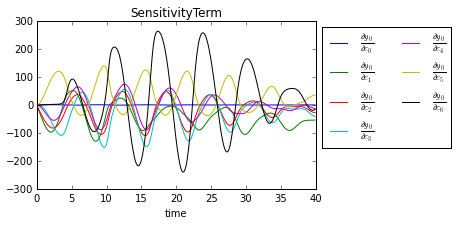

In [26]:
sample_trajectory = trajectories_with_sensitivities[0]
sample_trajectory.sensitivity_data

Each individual sensitivity data can be accessed through list indexing:

In [27]:
print sample_trajectory.sensitivity_data[0]

Trajectory object
description: <Sensitivity of Moment(array([1, 0, 0]), symbol=y_0) w.r.t. c_0>
time points: [0.0, 0.1, 0.2, 0.3, ...,39.6, 39.7, 39.8, 39.9]
values: [nan, 0.1, 0.2, 0.299, ...,0.555, 0.556, 0.556, 0.555]


The resulting trajectories are the values of each modelled moment for all time points point in the time range.

We provide convenience functions for plotting the sensitivity data as well. 
Trajectories with sensitivity data implement an extra plotting method called ``.plot_perturbations()``  that allows you plot the expected result of perturturbing a single parameter, specified in the function call by some small delta.

Example below plots the original trajectory andhow it is likely to change when the parameter $c_1$ is perturbed by $0.1$

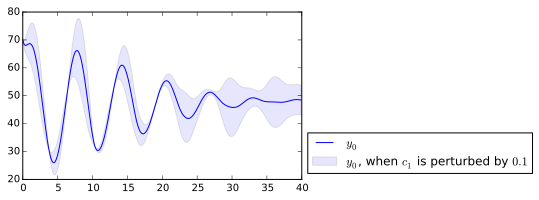

In [28]:
# Plot the actual trajectory
sample_trajectory.plot() 

# Plot the perturbation lines
sample_trajectory.plot_perturbations('c_1', delta=0.1) 

# Add legend
plt.legend(loc='lower left', bbox_to_anchor = (1, 0))

The delta parameter specified above is absolute perturbation, it is sometimes better to make it relative to the actual parameter value.

Similarly, multiple perturbations can be combined to a single plot, however that makes it quite difficult to read in most cases.

The recipe below provides a way to plot the resulting trajectories for relative perturbation of the first three parameters on separate figures:

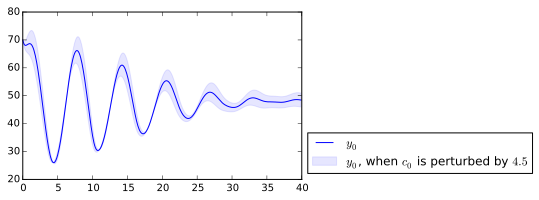

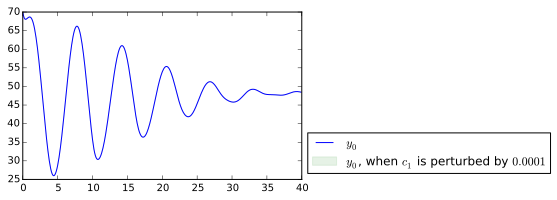

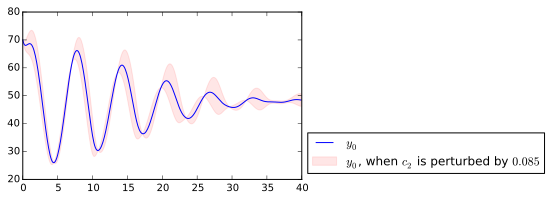

In [29]:
import itertools
colours = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y'])

# Loop through first three parameters and their values
for parameter, value in zip(ode_logn.parameters, parameters)[:3]:
   
    # Create a new figure
    plt.figure()
    
    # Plot the original trajectory
    sample_trajectory.plot()
    
    # Perturb by 5%
    delta = value * 0.05
    # We need to specify colours manually, as it defaults to blue otherwise
    colour = colours.next()
    
    # Plot the perturbations
    sample_trajectory.plot_perturbations(parameter, delta=delta, color=colour)
    
    plt.legend(loc='lower left', bbox_to_anchor = (1, 0))

## Stochastic Simulations

The section above described how to perform the simulations on ordinary differential equations generated by MEA/LNA approximations.
Here we are considering stochastic simmulation using Gillespie algorithm.

The major difference between stochastic simulation and the deterministic simulation routines is the type of a Problem object being simulated. Stochastic simulators need ``StochasticProblem`` objects, whereas the deterministic ones require ``ODEProblem`` objects as input.

The ``StochasticProblem`` object is just a wrapper around our ``Model`` object and can be directly initialised from it:

In [30]:
stochastic_problem = means.StochasticProblem(means.examples.MODEL_P53)

Stochastic simulations are performed by the ``SSASimulation`` class also available in the ``means.simulation`` package.
This object needs to be instantiated with the stochastic problem instance, the number of stochastic trajectories to generate and, optionally, the random seed.

In [31]:
# Let's go for only 10 trajectories in this tutorial, 
# realistically you would want at least 5000
N_SSA = 10 
ssa_simulation = means.SSASimulation(stochastic_problem, N_SSA, random_seed=42)

The newly created ``ssa_simulation`` object has a similar ``simulate_system`` method as a deterministic simulation object, and they can be used in the same way.

Let's check if we still have the parameters, initial conditions and timepoints defined from the sections above:

In [32]:
print 'Parameters:', parameters
print 'Initial conditions:', initial_conditions
print 'Timepoints: ', timepoints[:4], '...', timepoints[-4:]

Parameters: [90, 0.002, 1.7, 1.1, 0.93, 0.96, 0.01]
Initial conditions: [70, 30, 60]
Timepoints:  [ 0.   0.1  0.2  0.3] ... [ 39.6  39.7  39.8  39.9]


Generate the SSA simulated trajectory:

In [33]:
%%time 
ssa_trajectories \
    = ssa_simulation.simulate_system(parameters, initial_conditions, timepoints)

CPU times: user 6.41 s, sys: 66.3 ms, total: 6.47 s
Wall time: 11.6 s


These trajectories are directly plottable, just like any other trajectory:

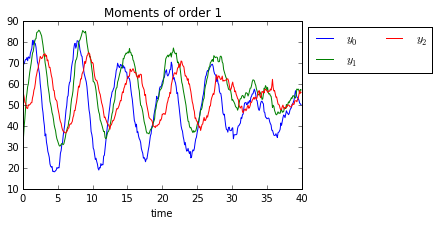

In [34]:
ssa_trajectories

Unlike the regular Simulation routines, stochastic simulation class accepts additional parameters in it's ``simulate_system()`` function.

One of these parameters is `number_of_processes` that makes the system perform the calculations on multiple processes, speeding them up on multi-CPU processors:

In [35]:
%%time 
ssa_trajectories \
    = ssa_simulation.simulate_system(parameters, initial_conditions, timepoints, 
                                     number_of_processes=2)

CPU times: user 18 ms, sys: 27.9 ms, total: 45.9 ms
Wall time: 3.82 s


``simulate_system()`` of the ``SSASimulation`` class also has a parameter that allows you to specify the maximum order for the moments generated from the simulation.

For instance, if we wanted to generate SSA approximated trajectories up to second-order moments, we could do this by setting ``max_moment_order=2``:

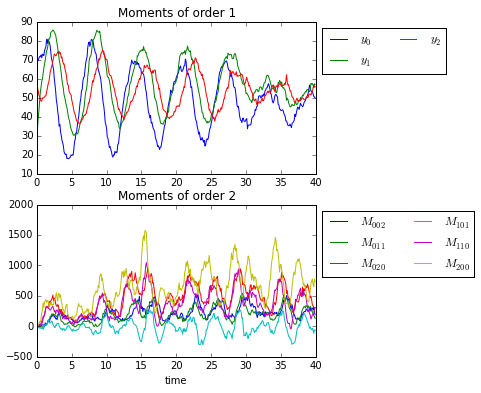

In [36]:
ssa_simulation.simulate_system(parameters, initial_conditions, timepoints, 
                               max_moment_order=2)

If the ``max_moment_order`` is set to 0, the simulation would return the trajectories separately, as list of ``TrajectoryCollection`` objects, without combining them into moments:

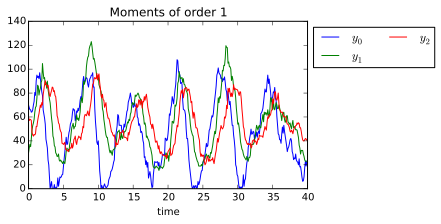

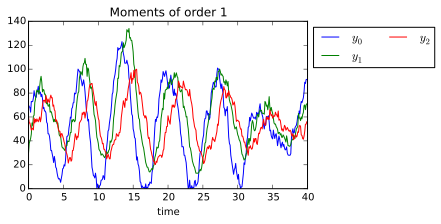

In [37]:
individual_trajectories \
    = ssa_simulation.simulate_system(parameters, initial_conditions, timepoints, 
                                     max_moment_order=0)
# Plot only the first two on separate plots:
plt.figure()
individual_trajectories[0].plot()
plt.figure()
individual_trajectories[1].plot()

And with that plot we finish this tutorial. Please continue to the next one

In [38]:
# Cleanup all matplotlib plots before leaving
plt.close()